## __08_05 감성 분석__
---
### 감성 분석 소개
__문서의 주관적인 감성/의견/감정/기분 등을 파악하기 위해 감성(Sentiment) 수치 계산<br> 감성 수치 - 긍정 감성 & 부정 감성 > 합산한 후 감성 결정__<br><br>
소셜 미디어, 여론조사, 온라인 리뷰, 피드백 등 분야에서 활용
<br><br>
- 지도학습: 학습 데이터, 타겟 레이블 값을 기반으로 감성 분석 학습을 수행한 뒤 다른 데이터의 감성 분석을 예측하는 방법으로 일반적인 텍스트 기반의 분류와 거의 동일<br><br>
- 비지도학습: 'Lexion'이라는 감성 어휘 사전 이용, 감성 분석을 위한 용어와 문맥에 대한 다양한 정보를 가지고 있으며 이를 이용해 문서의 긍정적, 부정적 감성 여부 판단

---
### 지도학습 기반 감성 분석 실습 - IMDB 영화평
영화 사이트 IMDB의 영화평의 텍스트를 분석해 긍정, 부정을 예측하는 모델 생성
<br><br>

https://www.kaggle.com/c/word2vec-nlp-tutorial/data
<br><br>
labeledTrainData.tsv 파일 사용 > .tsv는 탭으로 분리된 파일, read_csv 로 읽으면 됨 sep='\t'

In [1]:
import pandas as pd

review_df=pd.read_csv('./labeledTrainData.tsv', header=0, sep='\t', quoting=3)
review_df.head() 

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


- __id__: 각 데이터의 id
- __semtiment__: 영화평의 Sentiment 결과 값(Target label), 1 긍정, 0 부정 평가
- __review__: 영화평 텍스트

In [2]:
print(review_df['review'][0]) 

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

##### HTML 에서 추출한 데이터라 줄바꿈 태그가 존재 > 삭제!<br> DataFrame/Series 객체에서 str 적용하면 문자열 연산을 수행할 수 있음 <br> replace( )를 str에 적용해 줄바꿈 태그를 공백으로 변환
<br><br>
##### 영어가 아닌 숫자, 특수문자도 공백으로 변경 > 숫자, 특수문자를 찾고 변환하는 건 정규 표현식 이용 <br> DataFrame의 re.sub( )는 lambda 식을 이용해 적용

In [3]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review']=review_df['review'].str.replace('<br />', ' ')

# 파이썬의 정규 표현식 모듈인 re를 이용해 영어가 아닌 모든 문자 공백으로 변환
review_df['review']=review_df['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x)) 

##### 결정값 클래스 semtiment 칼럼을 별도로 추출해 결정값 데이터 세트 생성<br> 원본에서 id, semtiment를 삭제해 피처 데이터 세트 생성<br> train_test_split( )을 이용해 학습/테스트 데이터 분리

In [4]:
from sklearn.model_selection import train_test_split

class_df=review_df['sentiment']
feature_df=review_df.drop(['id', 'sentiment'], axis=1, inplace=False) 

X_train, X_test, y_train, y_test=train_test_split(feature_df, class_df, test_size=0.3, random_state=156)

X_train.shape, X_test.shape 

((17500, 1), (7500, 1))

##### 학습용 17500, 테스트용 7500개의 리뷰로 구성

---

##### review를 피처 벡터화한 후 ML 분류 알고리즘을 적용해 에측 성능 측정 > pipeline 객체 이용<br><br> Count 벡터화, TF-IDF 벡터화를 차례로 적용하고, 분류기로 Logistic Regression 활용 <br><br>정확도, ROC-AUC 모두 측정

__Count 벡터화__

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 스톱 워드 English & filtering, ngram (1,2) > CountVectorizer 수행
# LogisticRegression C=10
pipeline=Pipeline([('cnt_vect', CountVectorizer(stop_words='english', ngram_range=(1,2))),
                   ('lr_clf', LogisticRegression(C=10))])

# Pipeline 객체를 이용해 fit, predict > 학습, 예측
# predict_proba > roc_auc를 위해 수행
pipeline.fit(X_train['review'], y_train)
pred=pipeline.predict(X_test['review'])
pred_probs=pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도 {0:.4f}, ROC-AUC {1:.4f}'.format(accuracy_score(y_test, pred), 
                                                    roc_auc_score(y_test, pred_probs))) 

C:\Users\82109\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


예측 정확도 0.8860, ROC-AUC 0.9503


__TF-IDF__

In [6]:
# 스톱 워드 english & filtering, ngram (1, 2) > TF-IDF 수행
# LogisticRegression C=10
pipeline=Pipeline([('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
                   ('lr_clf', LogisticRegression(C=10))])

pipeline.fit(X_train['review'], y_train)
pipeline.predict(X_test['review'])
pred_probs=pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도 {0:.4f}, ROC-AUC {1:.4f}'.format(accuracy_score(y_test, pred),
                                                    roc_auc_score(y_test, pred_probs))) 

예측 정확도 0.8860, ROC-AUC 0.9598


---
### 비지도학습 기반 감성 분석
Lexicon이라는 감성 사전을 이용해 긍정, 부정 수치(감성 지수)를 판단<br><br>
- 감성 지수는 단어의 위치, 주변 단어, 문맥, POS(Part of Speech)를 참고해 결정
- NLTK 패키지로 구현<br><br>
__NLP에서 제공하는 WordNet 모듈__: 시맨틱 분석을 제공하는 어휘 사전 (semantic: 문맥상 의미)<br><br>
- WordNet은 다양한 상황에서 같은 어휘라도 다르게 사용되는 어휘의 시맨틱 정보를 제공<br> 각각의 품사(명사, 동사, 형용사, 부사)로 구성된 개별 단어를 Synset이라는 개념을 이용해 표현<br>Synset(Sets of cognitive synonyms)<br><br>
__NLTK를 포함한 대표적인 감성 사전__
- SentiWordNet
- VADER
- Pattern

---
### SentiWordNet을 이용한 감성 분석
WordNet을 이용하기 위해 NLTK를 셋업하고 WordNet 서브패키지, 데이터 세트를 내려 받음

In [7]:
import nltk
nltk.download('all') 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     C:\Users\8

[nltk_data]    |   Package senseval is already up-to-date!
[nltk_data]    | Downloading package sentiwordnet to
[nltk_data]    |     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]    |   Package sentiwordnet is already up-to-date!
[nltk_data]    | Downloading package sentence_polarity to
[nltk_data]    |     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]    |   Package sentence_polarity is already up-to-date!
[nltk_data]    | Downloading package shakespeare to
[nltk_data]    |     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]    |   Package shakespeare is already up-to-date!
[nltk_data]    | Downloading package sinica_treebank to
[nltk_data]    |     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]    |   Package sinica_treebank is already up-to-date!
[nltk_data]    | Downloading package smultron to
[nltk_data]    |     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]    |   Package smultron is already up-to-date!
[nltk_data]    | Downloading p

True

##### WordNet 모듈을 임포트해서 'present'에 대한 Synset 추출

In [8]:
from nltk.corpus import wordnet as wn

term='present'

# 'present'라는 단어로 wordnet의 synset 생성
synsets=wn.synsets(term)
print('synset 반환 type', type(synsets))
print('synset 반환 값 개수', len(synsets))
print('synset 반환 값', synsets) 

synset 반환 type <class 'list'>
synset 반환 값 개수 18
synset 반환 값 [Synset('present.n.01'), Synset('present.n.02'), Synset('present.n.03'), Synset('show.v.01'), Synset('present.v.02'), Synset('stage.v.01'), Synset('present.v.04'), Synset('present.v.05'), Synset('award.v.01'), Synset('give.v.08'), Synset('deliver.v.01'), Synset('introduce.v.01'), Synset('portray.v.04'), Synset('confront.v.03'), Synset('present.v.12'), Synset('salute.v.06'), Synset('present.a.01'), Synset('present.a.02')]


##### synset 호출 시 반환값은 여러 개의 synset 객체를 가지는 리스트, 18개 반환<br> 'present.n.01'은 POS(품사) 태그를 나타냄

In [9]:
for synset in synsets:
    print('##### Synset name:', synset.name(), '#####')
    print('POS', synset.lexname())
    print('Definition', synset.definition())
    print('Lemmas', synset.lemma_names(), '\n') 

##### Synset name: present.n.01 #####
POS noun.time
Definition the period of time that is happening now; any continuous stretch of time including the moment of speech
Lemmas ['present', 'nowadays'] 

##### Synset name: present.n.02 #####
POS noun.possession
Definition something presented as a gift
Lemmas ['present'] 

##### Synset name: present.n.03 #####
POS noun.communication
Definition a verb tense that expresses actions or states at the time of speaking
Lemmas ['present', 'present_tense'] 

##### Synset name: show.v.01 #####
POS verb.perception
Definition give an exhibition of to an interested audience
Lemmas ['show', 'demo', 'exhibit', 'present', 'demonstrate'] 

##### Synset name: present.v.02 #####
POS verb.communication
Definition bring forward and present to the mind
Lemmas ['present', 'represent', 'lay_out'] 

##### Synset name: stage.v.01 #####
POS verb.creation
Definition perform (a play), especially on a stage
Lemmas ['stage', 'present', 'represent'] 

##### Synset name: p

##### synset은 하나의 단어가 가질 수 있는 여러가지 시맨틱 정보를 개별 클래스로 나타낸 것

---

##### WordNet은 어휘간의 관계를 유사도로 나타낼 수 있음 > path_similarity( ) 메서드 제공

In [10]:
import pandas as pd
# synset 객체를 단어별로 생성
tree=wn.synset('tree.n.01')
lion=wn.synset('lion.n.01')
tiger=wn.synset('tiger.n.02')
cat=wn.synset('cat.n.01')
dog=wn.synset('dog.n.01')

entities=[tree, lion, tiger, cat, dog]
similarities=[]
entity_names=[entity.name().split(',')[0] for entity in entities]

# 단어별 synset을 반복하면서 다른 단어의 synset과 유사도 측정
for entity in entities:
    similarity=[round(entity.path_similarity(compared_entity), 2) for compared_entity in entities]
    similarities.append(similarity)
    
# 개별 단어별 synset과 다른 단어의 synset의 유사도를 DataFrame 형태로 저장
similarity_df=pd.DataFrame(similarities, columns=entity_names, index=entity_names)
similarity_df

,tree.n.01,lion.n.01,tiger.n.02,cat.n.01,dog.n.01
tree.n.01,1.00,0.07,0.07,0.08,0.12
lion.n.01,0.07,1.00,0.33,0.25,0.17
tiger.n.02,0.07,0.33,1.00,0.25,0.17
cat.n.01,0.08,0.25,0.25,1.00,0.20
dog.n.01,0.12,0.17,0.17,0.20,1.00


##### SentiWordNet은 WordNet Synset과 유사한 Senti_Synset 클래스를 가지고 있음<br> WordNet의 모듈이라 synsets과 비슷하게 클래스를 리스트 형태로 반환

In [11]:
import nltk
from nltk.corpus import sentiwordnet as swn

senti_synsets=list(swn.senti_synsets('slow'))
print('senti_synsets() 반환 type', type(senti_synsets))
print('senti_synsets() 반환 값 개수', len(senti_synsets))
print('senti_synsets() 반환 값', senti_synsets) 

senti_synsets() 반환 type <class 'list'>
senti_synsets() 반환 값 개수 11
senti_synsets() 반환 값 [SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


##### SentiSynsets 객체는 단어의 감성을 나타내는 감성 지수 & 객관성을 나타내는 객관성 지수를 가짐
<br><br>
##### 어떤 단어가 전혀 감성적이지 않으면 객관성 지수1, 감성 지수0<br>
---
##### father, fabulous 두 개 단어의 감성지수 & 객관성지수

In [12]:
import nltk
from nltk.corpus import sentiwordnet as swn

father=swn.senti_synset('father.n.01')
print('father 긍정감성 지수', father.pos_score())
print('father 부정감성 지수', father.neg_score())
print('father 객관성 지수', father.obj_score(), '\n')

fabulous=swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수', fabulous.pos_score())
print('fabulous 부정감성 지수', fabulous.neg_score())
print('fabulous 객관성 지수', fabulous.obj_score()) 

father 긍정감성 지수 0.0
father 부정감성 지수 0.0
father 객관성 지수 1.0 

fabulous 긍정감성 지수 0.875
fabulous 부정감성 지수 0.125
fabulous 객관성 지수 0.0


---
#### SentiWordNet을 이용한 영화 감상평 감성 분석
<br>
1. 문서(Document)를 문장(Sentence) 단위로 분해<br>
2. 다시 문장을 단어(Word) 단위로 토큰화하고 품사 태깅<br>
3. 품사 태깅된 단어 기반으로 synset 객체, senti_synset 객체 생성<br>
4. Senti_Synset에서 긍정/부정 감성 지수를 구하고 합산해 특정 값 이상일 때 긍정, 아닐때 부정으로 결정<br>

In [13]:
# 품사 태깅하는 함수
from nltk.corpus import wordnet as wn

# 간단한 NLTK PennTreebank Tag를 기반으로 WordNet 기반의 품사 Tag로 변환
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB

In [14]:
# 문서를 문장 > 단어 토큰 > 품사 태깅 > SentiSynset 클래스 생성 > Polarity Score 합산하는 함수
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    # 감성 지수 초기화
    sentiment=0.0
    tokens_count=0
    
    lemmatizer=WordNetLemmatizer()
    raw_sentences=sent_tokenize(text)
    # 분해된 ㅂ문장별로 단어 토큰 > 품사 태깅 > SentiSynset 생성 > 감성 지수 합산
    for raw_sentence in raw_sentences:
        # NLTK 기반의 품사 태깅 문장 추출
        tagged_sentence=pos_tag(word_tokenize(raw_sentence))
        for word, tag in tagged_sentence:
            # WordNet 기반 품사 태깅, 어근 추출
            wn_tag=penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma=lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            # 어근 추출한 단어, WordNet 기반 품사 태깅 입력 > Synset 객체 생성
            synsets=wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            # sentiwordnet의 감성 단어 분석으로 synset 추출
            # 모든 단어에 대해 긍정 감성 지수는 +, 부정은 -로 합산해 감성 지수 계산
            synset=synsets[0]
            swn_synset=swn.senti_synset(synset.name())
            sentiment += (swn_synset.pos_score() - swn_synset.neg_score())
            tokens_count+=1
            
    if not tokens_count:
        return 0
        
        # 총 score가 0 이상일 경우 긍정 1, 아니면 부정 0 반환
    if sentiment>=0:
        return 1
    
    return 0

##### IMDB 감상평의 개별 문서에 적용해 긍정, 부정 감성 예측 <br><br>
##### 새로운 칼럼으로 preds를 추가해 swn_polarity(text)로 반환된 평가 저장<br><br>
##### 실제 감성 평가인 sentiment 칼럼, swn_polarity(text) 반환된 결과의 __정확도/정밀도/재현율__ 측정

In [15]:
review_df['preds'] = review_df['review'].apply( lambda x : swn_polarity(x) )
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

In [18]:
# 수정된 get_clf_eval() 함수 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc)) 

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score 
from sklearn.metrics import recall_score, f1_score, roc_auc_score

print(confusion_matrix( y_target, preds))
print("정확도:", accuracy_score(y_target , preds))
print("정밀도:", precision_score(y_target , preds))
print("재현율:", recall_score(y_target, preds)) 

[[7668 4832]
 [3636 8864]]
정확도: 0.66128
정밀도: 0.647196261682243
재현율: 0.70912


---
### VADER를 이용한 감성 분석
소셜 미디어의 감성 분석 용도로 만들어진 룰 기반의 Lexicon<br><br>
IMDB의 감상평 1개만 감성 분석 수행

In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer=SentimentIntensityAnalyzer()
senti_scores=senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores) 

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


##### polarity_scores( )메서드는 딕셔너리 형태의 감성 점수 반환
- neg: 부정 / neu: 중립 / pos: 긍정
- compound: pos score를 적절히 조합해 -1부터 1까지 값을 감성 지수로 표현 > 0.1이상이면 긍정
<br><br>
__VADER를 이용해 IMDB 감성 분석__
- vader_polarity( ) 함수 생성.<br> 입력: 감상평 텍스트의 긍정/부정을 결정하는 임계값 <br>polarity_scores( )메서드로 감성 결과 반환<br><br>
- 문서별 감성 결과를 vader_preds 라는 새로운 칼럼에 저장, 예측 성능 측정


In [23]:
def vader_polarity(review, threshold=0.1):
    analyzer=SentimentIntensityAnalyzer()
    scores=analyzer.polarity_scores(review)
    
    # compound 값에 기반해 threshold 입력값보다 크면 1, 아니면 0 반환
    agg_score=scores['compound']
    final_sentiment=1 if agg_score>=threshold else 0
    return final_sentiment

# apply lambda 식을 이용해 레코드별 vader_polarity 수행, 결과를 vader_preds에 저장
review_df['vader_preds']=review_df['review'].apply(lambda x: vader_polarity(x, 0.1))
y_target=review_df['sentiment'].values
vader_preds=review_df['vader_preds'].values

In [24]:
print('#### VADER 예측 성능 평가 ####')
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score 
from sklearn.metrics import recall_score, f1_score, roc_auc_score

print(confusion_matrix( y_target, vader_preds))
print("정확도:", accuracy_score(y_target , vader_preds))
print("정밀도:", precision_score(y_target , vader_preds))
print("재현율:", recall_score(y_target, vader_preds)) 

#### VADER 예측 성능 평가 ####
[[ 6736  5764]
 [ 1867 10633]]
정확도: 0.69476
정밀도: 0.6484722815149113
재현율: 0.85064


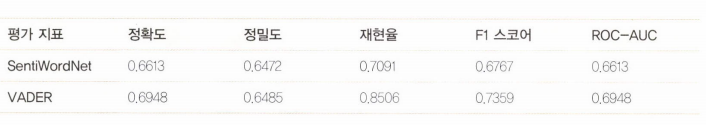

## __08_06 토픽 모델링(Topic Modeling) - 20 뉴스그룹__
__토픽 모델링: 문서 집합에 숨어 있는 주제를 찾아내는 것__<br><br>
- 숨겨진 주제를 효과적으로 표현할 수 있는 중심 단어를 함축적으로 추출<br><br>
- LSA(Latent Semantic Analysis)
- LDA(Latent Dirichlet Allocation)
    - count 기반의 벡터화만 사용

##### 20개의 주제 중 8개 주제를 추출하고 LDA 기반의 토픽 모델링 적용

In [25]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 전자공학, 의학 8개 주제 추출
cats=['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x',
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med']

# 위에서 cats 변수로 기재된 카테고리만 추출, categories에 cats 입력
news_df=fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories=cats,
                           random_state=0)

# LDA는 Count 기반의 벡터화만 적용
count_vect=CountVectorizer(max_df=0.95, max_features=1000, min_df=2,
                           stop_words='english', ngram_range=(1,2))
feat_vect=count_vect.fit_transform(news_df.data)
print('Count Vectorizer Shape', feat_vect.shape) 

Count Vectorizer Shape (7862, 1000)


##### 7862개의 문서가 1000개의 피처로 구성된 행렬 데이터  > 이 데이터 기바으로 LDA 토픽 모델링 수행

In [26]:
lda=LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect) 

LatentDirichletAllocation(n_components=8, random_state=0)

##### __LDA.fit(데이터세트) > components_ 속성을 가지게 됨__ <br>: 개별 토픽별로 word 피처가 얼마나 많이 그 토픽에 할당됐는지에 대한 수치 ,<br> 값이 클수록 토픽의 중심 word가 됨

In [27]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[2.46251560e+02, 1.18842248e+02, 1.51715288e+02, ...,
        1.00147234e+02, 7.63673375e+01, 1.17028758e+02],
       [1.25033020e-01, 1.25052288e-01, 1.25003012e-01, ...,
        1.10644583e+02, 1.51405141e-01, 5.09788954e+01],
       [1.25103419e-01, 1.25075224e-01, 1.25082214e-01, ...,
        6.72008817e+01, 1.25138615e-01, 2.48516614e+00],
       ...,
       [1.05055615e+02, 4.94858011e-01, 2.52075927e+01, ...,
        1.80695744e+01, 1.25115936e-01, 8.33321314e+00],
       [1.25147502e-01, 2.27058083e+02, 5.45176328e+00, ...,
        1.41751120e+00, 7.67217701e+01, 4.49861794e+01],
       [1.25096012e-01, 4.05666840e+00, 1.25049904e-01, ...,
        1.63821915e+02, 1.25049991e-01, 1.49550227e-01]])

##### array[8, 4000]으로 구성 > 8개 토픽별로 1000개의 word 피처가 해당 토픽별로 연관도 값을 가지고 있음<br><br>
##### components 값 만으로는 토픽별 word 연관도를 보기 어려워 display_topics( ) 함수를 만들어 연관도 높은 순으로 word 나열

In [29]:
def display_topic_words(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('\nTopic #',topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vect.get_feature_names()

# Topic별 가장 연관도가 높은 word를 15개만 추출
display_topic_words(lda, feature_names, 15)

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 전자공학, 의학 등 8개 주제를 추출. 


Topic # 0
year said don didn know game just time went people think did like say home

Topic # 1
god people jesus church think believe christ say does don christian know christians bible faith

Topic # 2
know does thanks like question information help time post advance book just looking group read

Topic # 3
edu com graphics mail ftp information available data pub list computer send software ca 3d

Topic # 4
israel jews jewish israeli dos dos arab turkish people war turkey dos state government greek history

Topic # 5
file image use program window jpeg windows display version color server files using available motif

Topic # 6
armenian armenians people health medical armenia disease turkish patients cancer russian 10 azerbaijan children 92

Topic # 7
like just don ve use good think time know way make used bike want need


## __08_07 문서 군집화 & 실습(Opinion Review 데이터 세트)__

---
### 문서 군집화 개념
__문서 군집화(Document Clustering): 비슷한 텍스트 구성의 문서를 군집화(Clustering)하는 것__
- 문서 군집화는 학습 데이터 세트가 필요 없는 비지도학습 기반

---
### Opinion Review 데이터 세트를 이용한 문서 군집화
- 51개의 텍스트 파일, Tripadvisor(호텔) <br>> Edmunds.com(자동차), Amazom.com(전자제품) 사이트의 리뷰 문서<br><br>
https://archive.ics.uci.edu/ml/datasets/Opinosis+Opinion+%26frasl%3B+Review
<br><br>
- 여러 개의 파일을 한 개의 DataFrame에 로딩해 데이터 처리<br> for 문으로 반복하면서 개별 파일명을 리스트에 추가하고, DF로 읽은 후 문자열로 반환해 리스트에 추가

In [31]:
import pandas as pd
import glob, os

path=r'C:\Users\82109\Desktop\20-1.5 쿠글\OpinosisDataset1.0\topics'
# path로 지정한 디렉터리 밑에 있는 모든 .data 파일의 파일명을 리스트로 취합
all_files=glob.glob(os.path.join(path, "*.data"))
filename_list=[]
opinion_text=[]

# 개별 파일의 파일명 filenmae_list로 취합
# 개별 파일의 내용 DF 로드 후 string으로 변환해 opinion_text로 취합
for file_ in all_files:
    # 개별 파일을 읽어서 DF로 생성
    df=pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    
    # 절대 경로로 주어진 파일명 가공 
    # 맨 마지막 .data 확장자 제거
    filename_=file_.split('\\')[-1]
    filename=filename_.split('.')[0]
    
    # 파일명 list, 파일 내용 list에 파일명과 파일 내용 추가
    filename_list.append(filename)
    opinion_text.append(df.to_string())
    
# 파일명 list와 파일 내용 list 객체를 DF로 생성
document_df=pd.DataFrame({'filename':filename_list, 'opinion_text': opinion_text})
document_df.head() 

,filename,opinion_text
0,accuracy_garmin_nuvi_255W_gps,...
1,bathroom_bestwestern_hotel_sfo,...
2,battery-life_amazon_kindle,...
3,battery-life_ipod_nano_8gb,...
4,battery-life_netbook_1005ha,...


##### TF-IDF 형태로 피처 벡터화 

In [34]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# nltk는 
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict))) 

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect=TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                           ngram_range=(1,2), min_df=0.05, max_df=0.85)
# opinion_text 칼럼 값으로 피처 벡터화 수행
feature_vect=tfidf_vect.fit_transform(document_df['opinion_text']) 

C:\Users\82109\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


##### K-Means 적용해 5개의 중심 기반으로 군집화가 어케 되는지 확인

In [36]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행
km_cluster=KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

##### 각 데이터별로 할당된 군집의 레이블을 파일명, 내용을 가지고 있는 document_df 에 cluster_label 칼럼 추가해 저장


In [37]:
document_df['cluster_label']=cluster_label
document_df.head() 

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,0
1,bathroom_bestwestern_hotel_sfo,...,1
2,battery-life_amazon_kindle,...,3
3,battery-life_ipod_nano_8gb,...,3
4,battery-life_netbook_1005ha,...,3


##### cluster_label=0 인 데이터 세트로 정렬

In [38]:
document_df[document_df['cluster_label']==0].sort_values(by='filename') 

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,0
8,directions_garmin_nuvi_255W_gps,...,0
9,display_garmin_nuvi_255W_gps,...,0
33,satellite_garmin_nuvi_255W_gps,...,0
34,screen_garmin_nuvi_255W_gps,...,0
43,speed_garmin_nuvi_255W_gps,...,0
47,transmission_toyota_camry_2007,...,0
48,updates_garmin_nuvi_255W_gps,...,0


cluster 0은 호텔 리뷰로 되어 있음을 확인 <br>
##### cluster_label=1 확인

In [39]:
document_df[document_df['cluster_label']==1].sort_values(by='filename') 

,filename,opinion_text,cluster_label
1,bathroom_bestwestern_hotel_sfo,...,1
13,food_holiday_inn_london,...,1
14,food_swissotel_chicago,...,1
15,free_bestwestern_hotel_sfo,...,1
20,location_bestwestern_hotel_sfo,...,1
21,location_holiday_inn_london,...,1
24,parking_bestwestern_hotel_sfo,...,1
28,price_holiday_inn_london,...,1
32,room_holiday_inn_london,...,1
30,rooms_bestwestern_hotel_sfo,...,1


1은 아이팟, 넷북 등의 포터블 전자기기에 대한 리뷰<br>
##### cluster_label=2 확인

In [40]:
document_df[document_df['cluster_label']==2].sort_values(by='filename') 

,filename,opinion_text,cluster_label
6,comfort_honda_accord_2008,...,2
7,comfort_toyota_camry_2007,...,2
16,gas_mileage_toyota_camry_2007,...,2
17,interior_honda_accord_2008,...,2
18,interior_toyota_camry_2007,...,2
22,mileage_honda_accord_2008,...,2
25,performance_honda_accord_2008,...,2
29,quality_toyota_camry_2007,...,2
37,seats_honda_accord_2008,...,2


아이팟, 넷북이 포함되어 있지만 주로 차량용 네비게이션으로 구성<br>
##### cluster_label=3 확인

In [41]:
document_df[document_df['cluster_label']==3].sort_values(by='filename') 

,filename,opinion_text,cluster_label
2,battery-life_amazon_kindle,...,3
3,battery-life_ipod_nano_8gb,...,3
4,battery-life_netbook_1005ha,...,3
26,performance_netbook_1005ha,...,3
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,3
49,video_ipod_nano_8gb,...,3


킨들 리뷰가 하나 섞여 있지만 대부분은 호텔 리뷰<br>
##### cluster_label=4 확인

In [42]:
document_df[document_df['cluster_label']==4].sort_values(by='filename') 

,filename,opinion_text,cluster_label
5,buttons_amazon_kindle,...,4
10,eyesight-issues_amazon_kindle,...,4
11,features_windows7,...,4
12,fonts_amazon_kindle,...,4
19,keyboard_netbook_1005ha,...,4
23,navigation_amazon_kindle,...,4
27,price_amazon_kindle,...,4
35,screen_ipod_nano_8gb,...,4
36,screen_netbook_1005ha,...,4
41,size_asus_netbook_1005ha,...,4


토요타, 혼다 등의 자동차에 대한 리뷰로 잘 군집화 됨

---
##### 군집 개수가 약간 많아서 세분화됨 > 군집을 3개로 줄여 확인

In [43]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_


# 소속 클러스터를 cluster_label 컬럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label') 

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,0
48,updates_garmin_nuvi_255W_gps,...,0
44,speed_windows7,...,0
43,speed_garmin_nuvi_255W_gps,...,0
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,0
41,size_asus_netbook_1005ha,...,0
36,screen_netbook_1005ha,...,0
35,screen_ipod_nano_8gb,...,0
34,screen_garmin_nuvi_255W_gps,...,0
33,satellite_garmin_nuvi_255W_gps,...,0


##### 0은 전자기기 리뷰, 1은 호텔 리뷰, 2는 자동차 리뷰로 잘 군집화 됨

---
### 군집별 핵심 단어 추출
각 군집에 속한 문서는 핵심 단어를 주축으로 군집화돼 있음<br><br>
- KMeans 객체는 군집을 기준으로 얼마나 피처가 중심에 가까운지 cluster_centers_ 속성으로 제공<br><br>
- 앞서 군집 3개로 생성한 KMeans 객체에서 cluster_centers_ 속성값을 가져와 확인

In [44]:
cluster_centers=km_cluster.cluster_centers_
print('cluster centers shape', cluster_centers.shape)
print(cluster_centers) 

cluster centers shape (3, 4611)
[[0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]]


##### 군집 3개, 4611개 단어로 구성 <br><br> 각 행의 배열 값은 4611개 피처가 개별 중심과 얼마나 가까운지 상대값으로 나타냄<br> > 0부터 1까지, 1에 가까울수록 중심과 가까움<br>
---
##### cluster_centers_ 속성값을 이용해 각 군집별 핵심 단어를 찾아보자<br><br> ndarray의 argsort()[:,::-1]를 이용하면  배열 내 값이 큰 순으로 정렬된 위치 인덱스 값 반환<br> 위치 인덱스 값으로 핵심 단어의 피처를 추출

In [45]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명들을 반환함. 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details

##### get_cluster_details( )를 호출하면 dictionary를 원소로 가지는 리스트인 cluster_detail 반환 <br><br> > cluster_datail에는 개별 군집번호, 핵심단어, 핵심단어 중심 위치 상댓값, 파일명 속성 값 정보 포함 <br> > 더 보기 좋게 표현하기 위해 print_cluster_details( ) 함수 작성

In [47]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :',cluster_detail['filenames'][:7])
        print('==================================================\n') 

In [51]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,
                                  feature_names=feature_names, clusters_num=3, top_n_features=10 )

print_cluster_details(cluster_details) 

####### Cluster 0
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 : ['accuracy_garmin_nuvi_255W_gps', 'battery-life_amazon_kindle', 'battery-life_ipod_nano_8gb', 'battery-life_netbook_1005ha', 'buttons_amazon_kindle', 'directions_garmin_nuvi_255W_gps', 'display_garmin_nuvi_255W_gps']

####### Cluster 1
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 : ['bathroom_bestwestern_hotel_sfo', 'food_holiday_inn_london', 'food_swissotel_chicago', 'free_bestwestern_hotel_sfo', 'location_bestwestern_hotel_sfo', 'location_holiday_inn_london', 'parking_bestwestern_hotel_sfo']

####### Cluster 2
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 : ['comfort_honda_accord_2008', 'comfort_toyota_camry_2007', 'gas_mileage_toyota_camry_2007', 'interior_h

##### 전자제품 리뷰 (cluster 0) 에서는 screen, battery, life 등과 같은 화면, 배터리 수명 등이 핵심 단어로 군집화<br><br>
##### 호텔 리뷰 (cluster 1) 에서는 room, hotel, service, location 등이 핵심 단어 <br><br>
##### 자동차 리뷰 (cluster 2) 에서는 interior, seat, mileage, comfortable이 핵심 단어